In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

(3404, 2120)


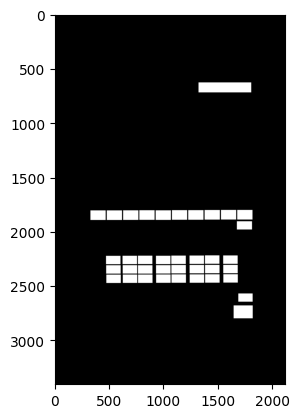

In [2]:
mask = cv2.imread('images/answer_scripts/mask_new copy.jpg', cv2.IMREAD_GRAYSCALE)
print(mask.shape)

plt.imshow(mask, cmap='gray')

(3404, 2120)


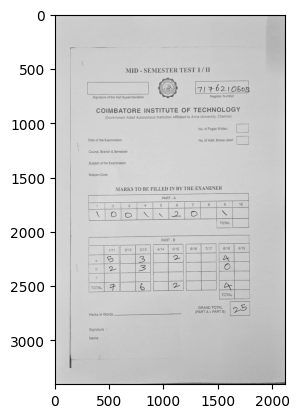

In [3]:
answer_script = cv2.imread('images/answer_scripts/new/1.jpg', cv2.IMREAD_GRAYSCALE)
print(answer_script.shape)

plt.imshow(answer_script, cmap='gray')

True

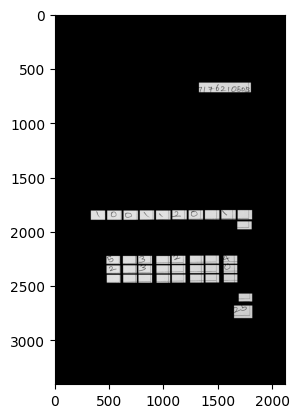

In [ ]:
kernel = np.ones((3, 5), np.uint8)  # Adjust the size as needed

# Erode the mask to create an inner mask, ignoring borders
inner_mask = cv2.erode(mask, kernel, iterations=10)

# Create a masked image using bitwise operations with the inner mask
final_masked_image = cv2.bitwise_and(answer_script, answer_script, mask=inner_mask)

plt.imshow(final_masked_image, cmap='gray')
cv2.imwrite('final_masked_image.jpg', final_masked_image)

In [21]:
def threshold_img(image):
    ret, thresh = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY_INV)
    return thresh

True

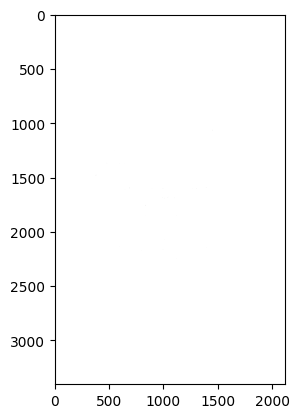

In [22]:
thresh_img = threshold_img(answer_script)
# thresh_img = cv2.bitwise_or(thresh_img, thresh_img, mask=inner_mask)

plt.imshow(thresh_img, cmap='gray')
cv2.imwrite('Threshold Image.jpg', thresh_img)

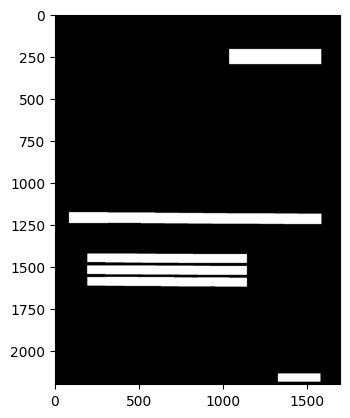

In [53]:
kernel = np.ones((1, 110), np.uint8)
dilated_img = cv2.dilate(inner_mask, kernel, iterations=1)
plt.imshow(dilated_img, cmap='gray')

In [54]:
contours, heirarchy = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
sorted_contours = np.array(list(filter(lambda c: cv2.contourArea(c) >= 10000, sorted_contours)), dtype=object)

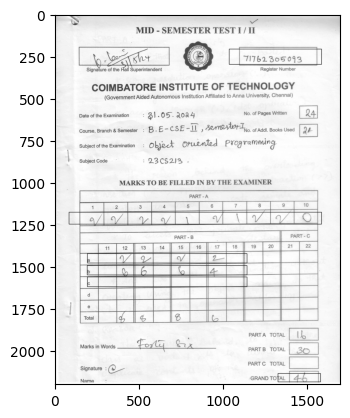

In [55]:
img2 = answer_script.copy()

for c in sorted_contours:
    if cv2.contourArea(c) < 10000:
        continue
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img2, (x, y), (x+w, y+h), (40, 100, 250), 2)

plt.imshow(img2, cmap='gray')

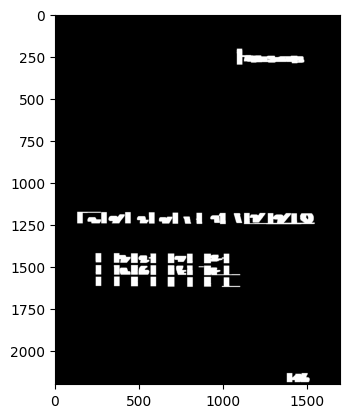

In [56]:
kernel = np.ones((5, 30), np.uint8)
dilated_img2 = cv2.dilate(thresh_img, kernel, iterations=1)
plt.imshow(dilated_img2, cmap='gray')

In [57]:
import tensorflow as tf
model = tf.keras.models.load_model('digit_recognizer.keras')

/Users/arun/Documents/co_attainment/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ValueError: File not found: filepath=digit_recognizer.keras. Please ensure the file is an accessible `.keras` zip file.

In [12]:
def rotate_img(image):
    # Define rotation angle
    angle = -25  # Specify the angle of rotation, negative for clockwise
    
    # Get the center of the image
    center = (image.shape[1] // 2, image.shape[0] // 2)
    
    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]),
                                   flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return rotated_image

1/1 [==============================] - 0s 50ms/step
[[2, 2, 2, 1, 0, 0, -1, 1, 2, 2], [2, -1, -1, 10, 10, 2, -1, -1], [8, -1, -1, -1, -1, 4, -1, -1], [-1, -1, -1, -1, -1, 6, -1, -1]]


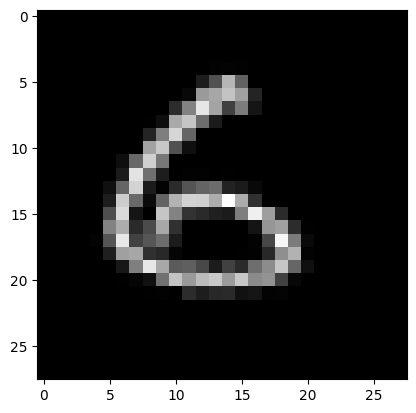

In [16]:
img3 = answer_script.copy()
marks = []

for c in sorted_contours: # Traversing each row
    # print(cv2.contourArea(c))
    # if cv2.contourArea(c) < 10000:
    #     continue
    x, y, w, h = cv2.boundingRect(c)
    roi_line = dilated_img[y:y+h, x:x+w]
    # print(roi_line.shape)
    line_mask = final_masked_image[y:y+h, x:x+w]

    line_img = cv2.bitwise_and(roi_line, roi_line, mask=line_mask)

    # plt.imshow(line_img, cmap='gray')

    cnt, hr = cv2.findContours(line_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda c: cv2.boundingRect(c)[0])
    sorted_contour_words = list(filter(lambda c: cv2.contourArea(c) >= 500, sorted_contour_words))
    
    for word in sorted_contour_words: # Traversing each number
        # print(cv2.contourArea(word))
        # if cv2.contourArea(word) < 500:
        #       continue
        x2, y2, w2, h2 = cv2.boundingRect(word)
        # cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (40, 100, 250), 2)
        num_img = img3[y+y2:y+y2+h2, x+x2:x+x2+w2]
        num_kernel = np.ones((5, 5), np.uint8)
        thresh_num_img = threshold_img(num_img)

        dilated_num_img = cv2.dilate(thresh_num_img, num_kernel, iterations=1)
        
        # plt.imshow(dilated_num_img, cmap='gray')

        digit_cnt, digit_hr = cv2.findContours(dilated_num_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        sorted_contour_digits = sorted(digit_cnt, key=lambda c: cv2.boundingRect(c)[0])
        number = None
        filtered_contour_digits = list(filter(lambda c: cv2.contourArea(c) >= 100, sorted_contour_digits))
        
        # print(len(filtered_contour_digits))

        if len(filtered_contour_digits) == 0:
            number = -1

        for digit in filtered_contour_digits: # Traversing each digit
            # print(cv2.contourArea(digit))
            # if cv2.contourArea(digit) < 100:
            #     continue
            x3, y3, w3, h3 = cv2.boundingRect(digit)
            # cv2.rectangle(img3, (x+x2+x3, y+y2+y3), (x+x2+x3+w3, y+y2+y3+h3), (40, 100, 250), 2)

            digit_img = img3[y+y2+y3:y+y2+y3+h3, x+x2+x3:x+x2+x3+w3]
            digit_img = threshold_img(digit_img)
            digit_img = cv2.copyMakeBorder(digit_img, 24, 24, 24, 24, cv2.BORDER_CONSTANT)
            digit_img = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_AREA)
            digit_img = rotate_img(digit_img)
            plt.imshow(digit_img, cmap='gray')

            prediction = model.predict(np.array([digit_img]))
            digit = np.argmax(prediction)
            # print(prediction[0][digit])
            if number is None:
                number = 0
            number = number * 10 + digit # Combining the predicted digits into a single number
            cv2.imwrite(f'{digit}.jpg', digit_img)
            
            # cv2.rectangle(img3, (x+x2+x3, y+y2+y3), (x+x2+x3+w3, y+y2+y3+h3), (40, 100, 250), 2) # Marking each digit in the image
        
        if number is not None:
            # print(number)
            marks.append(number)

# plt.imshow(img3, cmap='gray')
marks[:10] = [marks[:10]]
marks[1:9] = [marks[1:9]]
marks[2:10] = [marks[2:10]]
marks[3:11] = [marks[3:11]]
print(marks)
